In [1]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [2]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))
            X = torch.cat([X,X,X], dim=0)

        return X, y

In [3]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / (torch.norm(cor) + 1e-7)
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [ ]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(3, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(64)
        self.bn0b = nn.BatchNorm2d(64)
        
        self.conv1 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn1b = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv2c = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn2b = nn.BatchNorm2d(256)
        self.bn2c = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv3c = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn3b = nn.BatchNorm2d(512)
        self.bn3c = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4c = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)
        self.bn4c = nn.BatchNorm2d(512)
  
        self.fact0 = FeatureAct(64, 4)
        self.fact1 = FeatureAct(128, 4)
        self.fact2 = FeatureAct(256, 4)
        self.fact3 = FeatureAct(512, 4)
        self.fact4 = FeatureAct(512, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        x = self.conv2c(x)
        x = self.bn2c(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        x = self.conv3c(x)
        x = self.bn3c(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = self.conv4(x3)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv4b(x)
        x = self.bn4b(x)
        x = self.relu(x)
        x = self.conv4c(x)
        x = self.bn4c(x)
        x = self.relu(x)
        
        x4 = self.maxpool(x)
        x4 = self.fact4(x4)
        
        x = nn.Flatten()(x4)
        x = self.classifier(x)
        
        return x

In [7]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

In [8]:
from torchvision.models import vgg16_bn

pretrained = vgg16_bn(pretrained=True)
weights = pretrained.state_dict()
weights.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 

In [9]:
conv_indices = [0, 3, 7, 10, 14, 17, 20, 24, 27, 30, 34, 37, 40]
bn_indices = [1, 4, 8, 11, 15, 18, 21, 25, 28, 31, 35, 38, 41]
suffix = ['0', '0b', '1', '1b', '2', '2b', '2c', '3', '3b', '3c', '4', '4b', '4c']

In [10]:
rs_weights = model.state_dict()

for i, sf in enumerate(suffix):
    #conv
    target_conv_w = 'conv' + sf + '.weight'
    target_conv_b = 'conv' + sf + '.bias'
    
    src_conv_w = 'features.' + str(conv_indices[i]) + '.weight'
    src_conv_b = 'features.' + str(conv_indices[i]) + '.bias'
    
    #bn
    target_bn_w = 'bn' + sf + '.weight'
    target_bn_b = 'bn' + sf + '.bias'
    target_bn_mean = 'bn' + sf + '.running_mean'
    target_bn_var = 'bn' + sf + '.running_var'
    target_bn_nbatch = 'bn' + sf + '.num_batches_tracked'
    
    src_bn_w = 'features.' + str(bn_indices[i]) + '.weight'
    src_bn_b = 'features.' + str(bn_indices[i]) + '.bias'
    src_bn_mean = 'features.' + str(bn_indices[i]) + '.running_mean'
    src_bn_var = 'features.' + str(bn_indices[i]) + '.running_var'
    src_bn_nbatch = 'features.' + str(bn_indices[i]) + '.num_batches_tracked'
    
    # transfer
    rs_weights[target_conv_w] = weights[src_conv_w]
    rs_weights[target_conv_b] = weights[src_conv_b]
    
    rs_weights[target_bn_w] = weights[src_bn_w]
    rs_weights[target_bn_b] = weights[src_bn_b]
    rs_weights[target_bn_mean] = weights[src_bn_mean]
    rs_weights[target_bn_var] = weights[src_bn_var]
    rs_weights[target_bn_nbatch] = weights[src_bn_nbatch]
        

In [11]:
model.load_state_dict(rs_weights)

<All keys matched successfully>

In [12]:
best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [13]:
model_path = './featureactv34_vgg16pretrained_size224_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/3589 [00:00<?, ?it/s]

Epoch:  1


Loss=1.0058526992797852 Batch_id=3588 Accuracy=0.6: 100%|██████████| 3589/3589 [1:00:36<00:00,  1.01s/it]  


- Avg.loss: 1.607 | Avg.acc: 0.390
- Avg. val_loss: 1.466 | Avg. val_acc: 0.442


  0%|          | 0/3589 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.730065941810608 Batch_id=3588 Accuracy=0.2: 100%|██████████| 3589/3589 [1:00:41<00:00,  1.01s/it]   


- Avg.loss: 1.493 | Avg.acc: 0.427
- Avg. val_loss: 1.381 | Avg. val_acc: 0.476


  0%|          | 0/3589 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.5471301078796387 Batch_id=194 Accuracy=0.625:   5%|▌         | 195/3589 [03:18<57:32,  1.02s/it]


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7fba0f8dc588>,
 0.6812482585678462)

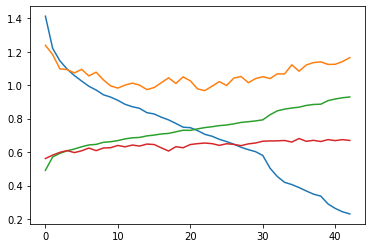

In [24]:
import pickle
pickle.dump(hist, open('featureactv34_vgg16pretrained_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [22]:
test_model = torch.load('featureactv34_vgg16pretrained_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.046 | Avg. val_acc: 0.686


In [ ]:
model_path = './featureactv34_vgg16pretrained_full_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.4806737899780273 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [02:42<00:00,  1.38it/s]

- Avg.loss: 1.471 | Avg.acc: 0.463



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.356 | Avg. val_acc: 0.522
* Update optimal model
Epoch:  2


Loss=1.2774708271026611 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]

- Avg.loss: 1.250 | Avg.acc: 0.554


- Avg. val_loss: 1.223 | Avg. val_acc: 0.565


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.1274375915527344 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]

- Avg.loss: 1.173 | Avg.acc: 0.579


- Avg. val_loss: 1.188 | Avg. val_acc: 0.569


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.2577461004257202 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [02:43<00:00,  1.37it/s]

- Avg.loss: 1.121 | Avg.acc: 0.598


- Avg. val_loss: 1.117 | Avg. val_acc: 0.587


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.213525652885437 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]

- Avg.loss: 1.086 | Avg.acc: 0.611


- Avg. val_loss: 1.112 | Avg. val_acc: 0.595


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.887481689453125 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]

- Avg.loss: 1.050 | Avg.acc: 0.621


- Avg. val_loss: 1.083 | Avg. val_acc: 0.607


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.2023345232009888 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]

- Avg.loss: 1.021 | Avg.acc: 0.631


- Avg. val_loss: 1.027 | Avg. val_acc: 0.615


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.1452763080596924 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]

- Avg.loss: 0.997 | Avg.acc: 0.640


- Avg. val_loss: 1.070 | Avg. val_acc: 0.617


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.0299084186553955 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]

- Avg.loss: 0.979 | Avg.acc: 0.643


- Avg. val_loss: 1.021 | Avg. val_acc: 0.625


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.0806553363800049 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [02:44<00:00,  1.37it/s]

- Avg.loss: 0.956 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.614
Epoch:  11


Loss=0.9848387241363525 Batch_id=94 Accuracy=0.65625:  42%|████▏     | 95/225 [01:10<01:34,  1.38it/s]  

In [11]:
test_model = torch.load('featureactv34_vgg16pretrained_full_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.047 | Avg. val_acc: 0.688


## v3.4 with multi-head

In [6]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, n_heads=4):
        super(FeatureAct, self).__init__()
        
        self.n_heads = n_heads
        self.dim = src_depth // n_heads
        self.batchnorm = nn.BatchNorm2d(src_depth)
        
        self.pos = nn.Parameter(torch.zeros(src_depth, img_size, img_size))
        self.softmax = nn.Softmax(dim=2)
        self.map_conv = nn.Conv2d(src_depth, 3*src_depth, kernel_size=1, padding=False)
        self.proj_conv = nn.Conv2d(src_depth, src_depth, kernel_size=1, padding=False)
        
    def forward(self, x):
        x = x + self.pos
        x_norm = self.batchnorm(x)
        
        x_map = self.map_conv(x_norm)
        x_map = x_map.view(-1, 3, x.size(-3), x.size(-2), x.size(-1))
        
        main_features, src_features, target_features = x_map[:,0], x_map[:,1], x_map[:,2]
        
        src_features = src_features.view(-1, self.n_heads, self.dim, src_features.size(-2), src_features.size(-1))
        target_features = target_features.view(-1, self.n_heads, self.dim, target_features.size(-2), target_features.size(-1))
        main_features = main_features.view(-1, self.n_heads, self.dim, main_features.size(-2), main_features.size(-1))
        
        cor = nn.Flatten(-2)(src_features[:, :, None, :, :]).permute(0,1,3,2,4) * nn.Flatten(-2)(target_features[:, :, None, :, :])
        cor = cor * (cor.size(2)**(-0.5))
        cor = self.softmax(cor)
    
        cor_feature = [(main_features * cor[:, :, :, k].view(-1, self.n_heads, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(2, keepdim=True) for k in range(cor.size(2))]
        cor_feature = torch.cat(cor_feature, dim=2)
        cor_feature = cor_feature.view(-1, self.n_heads*self.dim, cor_feature.size(-2), cor_feature.size(-1))
        
        cor_feature = self.proj_conv(cor_feature)
        
        x = x + cor_feature
        
        return x

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(3, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(64)
        self.bn0b = nn.BatchNorm2d(64)
        
        self.conv1 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn1b = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv2c = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn2b = nn.BatchNorm2d(256)
        self.bn2c = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv3c = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn3b = nn.BatchNorm2d(512)
        self.bn3c = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4b = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.conv4c = nn.Conv2d(512, 512, kernel_size=(3,3), padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)
        self.bn4c = nn.BatchNorm2d(512)
  
        self.fact0 = FeatureAct(64, 24, 4)
        self.fact1 = FeatureAct(128, 12, 4)
        self.fact2 = FeatureAct(256, 6, 4)
        self.fact3 = FeatureAct(512, 3, 4)
        self.fact4 = FeatureAct(512, 1, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        x = self.conv2c(x)
        x = self.bn2c(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        x = self.conv3c(x)
        x = self.bn3c(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = self.conv4(x3)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv4b(x)
        x = self.bn4b(x)
        x = self.relu(x)
        x = self.conv4c(x)
        x = self.bn4c(x)
        x = self.relu(x)
        
        x4 = self.maxpool(x)
        x4 = self.fact4(x4)
        
        x = nn.Flatten()(x4)
        x = self.classifier(x)
        
        return x

In [13]:
best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [14]:
model_path = './featureactv34_multihead_vgg16pretrained_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3851077556610107 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 1.533 | Avg.acc: 0.436



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.369 | Avg. val_acc: 0.506
* Update optimal model
Epoch:  2


Loss=1.183294653892517 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [10:36<00:00,  2.83s/it]

- Avg.loss: 1.306 | Avg.acc: 0.528


- Avg. val_loss: 1.197 | Avg. val_acc: 0.566


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.0546914339065552 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 1.217 | Avg.acc: 0.561


- Avg. val_loss: 1.187 | Avg. val_acc: 0.573


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=0.8662161827087402 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 1.162 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.231 | Avg. val_acc: 0.557
Epoch:  5


Loss=1.2856237888336182 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 1.124 | Avg.acc: 0.596


- Avg. val_loss: 1.108 | Avg. val_acc: 0.603


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.2483161687850952 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [10:36<00:00,  2.83s/it]

- Avg.loss: 1.089 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.131 | Avg. val_acc: 0.593
Epoch:  7


Loss=1.107138991355896 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 1.059 | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.592
Epoch:  8


Loss=0.9566487669944763 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 1.037 | Avg.acc: 0.622


- Avg. val_loss: 1.059 | Avg. val_acc: 0.623


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.9293116927146912 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 1.013 | Avg.acc: 0.631


- Avg. val_loss: 1.043 | Avg. val_acc: 0.625


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.9652232527732849 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.989 | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.124 | Avg. val_acc: 0.587
Epoch:  11


Loss=0.9901310801506042 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.979 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.621
Epoch:  12


Loss=0.9612176418304443 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.956 | Avg.acc: 0.652



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.619
Epoch:  13


Loss=0.977631151676178 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.949 | Avg.acc: 0.657


- Avg. val_loss: 1.021 | Avg. val_acc: 0.635


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.9015731811523438 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.930 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037 | Avg. val_acc: 0.624
Epoch:  15


Loss=1.0837103128433228 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.917 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.622
Epoch:  16


Loss=0.920028805732727 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.901 | Avg.acc: 0.673


- Avg. val_loss: 1.047 | Avg. val_acc: 0.636


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=0.8150601387023926 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.886 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.630
Epoch:  18


Loss=0.9705641269683838 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.874 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059 | Avg. val_acc: 0.619
Epoch:  19


Loss=0.6282781362533569 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.855 | Avg.acc: 0.691



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.995 | Avg. val_acc: 0.636
Epoch:  20


Loss=1.056483507156372 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [10:36<00:00,  2.83s/it]

- Avg.loss: 0.841 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022 | Avg. val_acc: 0.631
Epoch:  21


Loss=0.8913602828979492 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.831 | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.636
Epoch:  22


Loss=0.8241221904754639 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.818 | Avg.acc: 0.706


- Avg. val_loss: 1.016 | Avg. val_acc: 0.640


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=0.8805398941040039 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.800 | Avg.acc: 0.714


- Avg. val_loss: 0.997 | Avg. val_acc: 0.644


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=0.8699204921722412 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.796 | Avg.acc: 0.713



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010 | Avg. val_acc: 0.643
Epoch:  25


Loss=0.8862035870552063 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.781 | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066 | Avg. val_acc: 0.606
Epoch:  26


Loss=0.6869802474975586 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.758 | Avg.acc: 0.728


- Avg. val_loss: 0.970 | Avg. val_acc: 0.656


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=0.8877677917480469 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.745 | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.008 | Avg. val_acc: 0.643
Epoch:  28


Loss=1.1952608823776245 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.740 | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.990 | Avg. val_acc: 0.651
Epoch:  29


Loss=0.7442378401756287 Batch_id=76 Accuracy=0.7421875:  34%|███▍      | 77/225 [03:39<06:59,  2.83s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.1659773886203766 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.296 | Avg.acc: 0.907



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.659
Epoch:  47


Loss=0.48793962597846985 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.287 | Avg.acc: 0.909



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162 | Avg. val_acc: 0.661
Epoch:  48


Loss=0.17268116772174835 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.276 | Avg.acc: 0.914



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.153 | Avg. val_acc: 0.662
Epoch:  49


Loss=0.2244265228509903 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.259 | Avg.acc: 0.918



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.193 | Avg. val_acc: 0.661
Epoch:  50


Loss=0.3828030526638031 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.248 | Avg.acc: 0.924



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.659
Epoch    50: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  51


Loss=0.27245593070983887 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.236 | Avg.acc: 0.929



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.184 | Avg. val_acc: 0.661
Epoch:  52


Loss=0.2925160825252533 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.211 | Avg.acc: 0.936



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.220 | Avg. val_acc: 0.659
Epoch:  53


Loss=0.24972839653491974 Batch_id=50 Accuracy=0.9140625:  23%|██▎       | 51/225 [02:26<08:12,  2.83s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.2114536315202713 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.162 | Avg.acc: 0.954



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.251 | Avg. val_acc: 0.663
Epoch:  60


Loss=0.07367890328168869 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.155 | Avg.acc: 0.956



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.271 | Avg. val_acc: 0.661
Epoch:  61


Loss=0.18756072223186493 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.149 | Avg.acc: 0.958



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.272 | Avg. val_acc: 0.660
Epoch:  62


Loss=0.3093653619289398 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.150 | Avg.acc: 0.958



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.292 | Avg. val_acc: 0.660
Epoch:  63


Loss=0.11467526108026505 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.145 | Avg.acc: 0.960



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.282 | Avg. val_acc: 0.661
Epoch:  64


Loss=0.13467249274253845 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [10:37<00:00,  2.83s/it]

- Avg.loss: 0.139 | Avg.acc: 0.962



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.296 | Avg. val_acc: 0.658
Epoch:  65


Loss=0.08184321224689484 Batch_id=23 Accuracy=0.96875:  11%|█         | 24/225 [01:12<10:07,  3.02s/it]  


KeyboardInterrupt: 

([<matplotlib.lines.Line2D at 0x7f402b5b32e8>,
 0.6709389802173308)

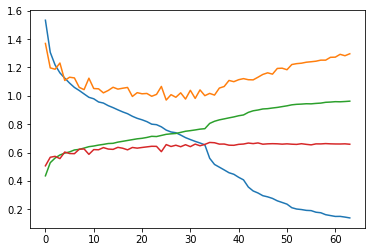

In [18]:
import pickle
pickle.dump(hist, open('featureactv34_multihead_vgg16pretrained_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [17]:
test_model = torch.load('featureactv34_multihead_vgg16pretrained_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 0.993 | Avg. val_acc: 0.676


# Resnet

## Resnet 50

In [6]:
from torchvision.models import resnet50

In [7]:
from resnet import Bottleneck, conv1x1, conv3x3

In [8]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.softmax = nn.Softmax(dim=2)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor / (torch.norm(cor) + 1e-7)
        cor = self.softmax(cor)
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:, :, k].view(-1, src_features.size(-3), src_features.size(-2), src_features.size(-1))).sum(1, keepdim=True) for k in range(cor.size(2))], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [8]:
class BaselineFeatureAct(nn.Module):

    def __init__(
        self,
        block,
        layers,
        num_classes=7,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation = None,
        norm_layer = None
    ):
        super(BaselineFeatureAct, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]
                    
                    
        self.fact1 = FeatureAct(256, 4)
        self.fact2 = FeatureAct(512, 4)
        self.fact3 = FeatureAct(1024, 4)
        self.fact4 = FeatureAct(2048, 4)

    def _make_layer(self, block, planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.fact1(x)
        x = self.layer2(x)
        x = self.fact2(x)
        x = self.layer3(x)
        x = self.fact3(x)
        x = self.layer4(x)
        x = self.fact4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [9]:
pretrained = resnet50(pretrained=True)
model = BaselineFeatureAct(Bottleneck, [3, 4, 6, 3])

In [10]:
# transfer weights
rs_weights = model.state_dict()
weights = pretrained.state_dict()

for k,v in weights.items():
    if 'fc.' in k:
        continue
    rs_weights[k] = v
    
model.load_state_dict(rs_weights)

<All keys matched successfully>

In [11]:
best_acc = 0.0
hist = []

epochs=50
device = torch.device('cuda')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [ ]:
model_path = './featureactv34_resnet50pretrained_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2877111434936523 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [41:20<00:00,  5.52s/it]

- Avg.loss: 1.459 | Avg.acc: 0.439



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.533 | Avg. val_acc: 0.500
* Update optimal model
Epoch:  2


Loss=1.3961284160614014 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [41:20<00:00,  5.52s/it]

- Avg.loss: 1.286 | Avg.acc: 0.509


- Avg. val_loss: 1.482 | Avg. val_acc: 0.509


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.0491409301757812 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [41:20<00:00,  5.52s/it]

- Avg.loss: 1.232 | Avg.acc: 0.529


- Avg. val_loss: 1.827 | Avg. val_acc: 0.519


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.1520899534225464 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [41:20<00:00,  5.52s/it]

- Avg.loss: 1.217 | Avg.acc: 0.539


- Avg. val_loss: 1.152 | Avg. val_acc: 0.569


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.1502912044525146 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [41:20<00:00,  5.52s/it]

- Avg.loss: 1.197 | Avg.acc: 0.543


- Avg. val_loss: 1.137 | Avg. val_acc: 0.573


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.0357862710952759 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [41:19<00:00,  5.52s/it]

- Avg.loss: 1.151 | Avg.acc: 0.565


- Avg. val_loss: 1.119 | Avg. val_acc: 0.576


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.9075380563735962 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [41:19<00:00,  5.52s/it]

- Avg.loss: 1.151 | Avg.acc: 0.567


- Avg. val_loss: 1.100 | Avg. val_acc: 0.584


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.3537015914916992 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [41:19<00:00,  5.52s/it]

- Avg.loss: 1.111 | Avg.acc: 0.579



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.170 | Avg. val_acc: 0.578
Epoch:  9


Loss=1.160040020942688 Batch_id=14 Accuracy=0.515625:   3%|▎         | 14/449 [01:23<40:07,  5.53s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.0642530918121338 Batch_id=340 Accuracy=0.609375:  76%|███████▌  | 341/449 [31:24<09:56,  5.52s/it]

([<matplotlib.lines.Line2D at 0x7f736cd670b8>,
 0.641404290888827)

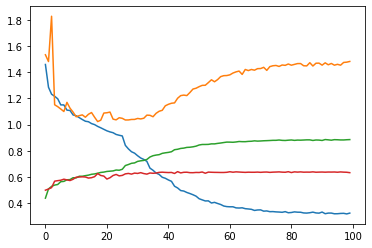

In [15]:
import pickle
pickle.dump(hist, open('featureactv34_resnet50pretrained_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [16]:
test_model = torch.load('featureactv34_resnet50pretrained_model.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.143 | Avg. val_acc: 0.648


### Resnet50 - add FeatureAct without alternating to the main flow

In [9]:
class BaselineFeatureAct(nn.Module):

    def __init__(
        self,
        block,
        layers,
        num_classes=7,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation = None,
        norm_layer = None
    ):
        super(BaselineFeatureAct, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
#                                        dilate=replace_stride_with_dilation[1])
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
#                                        dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
                        nn.Linear(512, 512),
                        nn.BatchNorm1d(512),
                        nn.ReLU(512),
                        nn.Dropout(0.4),
            
                        nn.Linear(512, num_classes),
                        nn.BatchNorm1d(num_classes))
#         self.fc = nn.Linear(5120, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]
                    
                    
        self.fact2 = FeatureAct(512, 4)
        
        
        # freeze resnet original feature extractor
        for param in self.conv1.parameters():
            param.requires_grad = False
            
        for param in self.bn1.parameters():
            param.requires_grad = False
            
        for param in self.layer1.parameters():
            param.requires_grad = False
            
        for param in self.layer2.parameters():
            param.requires_grad = False
            
#         for param in self.layer3.parameters():
#             param.requires_grad = False
            
#         for param in self.layer4.parameters():
#             param.requires_grad = False

    def _make_layer(self, block, planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fact2(x)
        
        x = torch.flatten(self.avgpool(x),1)
        
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [10]:
from torchvision.models import resnet50

In [11]:
from resnet import Bottleneck, conv1x1, conv3x3

In [12]:
pretrained = resnet50(pretrained=True)
model = BaselineFeatureAct(Bottleneck, [3, 4, 6, 3])

In [13]:
# transfer weights
rs_weights = model.state_dict()
weights = pretrained.state_dict()

for k,v in weights.items():
    if 'fc.' in k:
        continue
        
    if k in rs_weights:
        rs_weights[k] = v
    
model.load_state_dict(rs_weights)

<All keys matched successfully>

In [14]:
best_acc = 0.0
hist = []

epochs=50
device = torch.device('cuda')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


In [15]:
model_path = './featureactv34_resnet50pretrained_model2.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.469597578048706 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.545 | Avg.acc: 0.433



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.477 | Avg. val_acc: 0.457
* Update optimal model
Epoch:  3


Loss=1.5397411584854126 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.475 | Avg.acc: 0.454



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.422 | Avg. val_acc: 0.467
* Update optimal model
Epoch:  4


Loss=1.6798076629638672 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.434 | Avg.acc: 0.466



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.394 | Avg. val_acc: 0.478
* Update optimal model
Epoch:  5


Loss=1.6294565200805664 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.402 | Avg.acc: 0.474



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.400 | Avg. val_acc: 0.474
Epoch:  6


Loss=1.5086277723312378 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.384 | Avg.acc: 0.482



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.396 | Avg. val_acc: 0.476
Epoch:  7


  0%|          | 0/225 [00:00<?, ?it/s]uracy=0.46875:  97%|█████████▋| 218/225 [03:43<00:07,  1.02s/it]   

- Avg. val_loss: 1.337 | Avg. val_acc: 0.504
* Update optimal model
Epoch:  8


Loss=1.2107644081115723 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.341 | Avg.acc: 0.494



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.319 | Avg. val_acc: 0.507
* Update optimal model
Epoch:  10


Loss=1.2365326881408691 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [03:48<00:00,  1.02s/it]

- Avg.loss: 1.330 | Avg.acc: 0.499



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.392 | Avg. val_acc: 0.476
Epoch:  11


Loss=1.5408949851989746 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [03:48<00:00,  1.02s/it]

- Avg.loss: 1.324 | Avg.acc: 0.498



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.295 | Avg. val_acc: 0.515
* Update optimal model
Epoch:  12


Loss=1.1663731336593628 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.319 | Avg.acc: 0.500



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.306 | Avg. val_acc: 0.511
Epoch:  13


Loss=1.5809545516967773 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.312 | Avg.acc: 0.503



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.310 | Avg. val_acc: 0.508
Epoch:  14


Loss=1.1216144561767578 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.308 | Avg.acc: 0.504



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.304 | Avg. val_acc: 0.509
Epoch:  15


Loss=1.2473602294921875 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.300 | Avg.acc: 0.508



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.293 | Avg. val_acc: 0.504
Epoch:  16


Loss=1.3118177652359009 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.295 | Avg.acc: 0.507



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.285 | Avg. val_acc: 0.512
Epoch:  17


Loss=1.2008976936340332 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.283 | Avg.acc: 0.513



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.287 | Avg. val_acc: 0.514
Epoch:  18


Loss=1.2556179761886597 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.279 | Avg.acc: 0.513



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.360 | Avg. val_acc: 0.488
Epoch:  19


Loss=1.2918850183486938 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.278 | Avg.acc: 0.514



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.268 | Avg. val_acc: 0.519
* Update optimal model
Epoch:  20


Loss=1.2727762460708618 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [03:48<00:00,  1.02s/it]

- Avg.loss: 1.267 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.281 | Avg. val_acc: 0.509
Epoch:  21


Loss=1.5122277736663818 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [03:48<00:00,  1.02s/it]

- Avg.loss: 1.273 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.277 | Avg. val_acc: 0.515
Epoch:  22


Loss=1.3938122987747192 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.266 | Avg.acc: 0.524



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.260 | Avg. val_acc: 0.525
* Update optimal model
Epoch:  23


Loss=1.4523723125457764 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.261 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.260 | Avg. val_acc: 0.523
Epoch:  24


Loss=1.2984548807144165 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.257 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.258 | Avg. val_acc: 0.515
Epoch:  25


Loss=1.2206213474273682 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.252 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.260 | Avg. val_acc: 0.521
Epoch:  26


Loss=1.466007947921753 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.250 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.521
Epoch:  27


Loss=1.4135571718215942 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.250 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.259 | Avg. val_acc: 0.520
Epoch:  28


Loss=1.6683428287506104 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.244 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.279 | Avg. val_acc: 0.518
Epoch:  29


Loss=1.0892680883407593 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.247 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.253 | Avg. val_acc: 0.525
Epoch:  30


Loss=1.414521336555481 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.244 | Avg.acc: 0.529



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.258 | Avg. val_acc: 0.526
* Update optimal model
Epoch:  31


Loss=1.739348292350769 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.240 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.263 | Avg. val_acc: 0.521
Epoch:  32


Loss=1.3661845922470093 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.241 | Avg.acc: 0.526



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.238 | Avg. val_acc: 0.531
* Update optimal model
Epoch:  33


Loss=1.1389179229736328 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.240 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.240 | Avg. val_acc: 0.534
* Update optimal model
Epoch:  34


Loss=1.0420323610305786 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.233 | Avg.acc: 0.535



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.246 | Avg. val_acc: 0.526
Epoch:  35


Loss=1.3541070222854614 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.228 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248 | Avg. val_acc: 0.529
Epoch:  36


Loss=1.332890272140503 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.223 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.521
Epoch:  37


Loss=1.3247041702270508 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.228 | Avg.acc: 0.535



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.230 | Avg. val_acc: 0.536
* Update optimal model
Epoch:  38


Loss=1.2100530862808228 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.224 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.278 | Avg. val_acc: 0.515
Epoch:  39


Loss=1.0878551006317139 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.218 | Avg.acc: 0.536



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.257 | Avg. val_acc: 0.522
Epoch:  40


Loss=1.1257281303405762 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.217 | Avg.acc: 0.539


- Avg. val_loss: 1.233 | Avg. val_acc: 0.541


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=1.4124476909637451 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.218 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.231 | Avg. val_acc: 0.530
Epoch:  42


Loss=1.2084107398986816 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.218 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.233 | Avg. val_acc: 0.536
Epoch:  43


Loss=1.2149057388305664 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:48<00:00,  1.02s/it]

- Avg.loss: 1.210 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.255 | Avg. val_acc: 0.527
Epoch:  44


Loss=1.3109512329101562 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.213 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.213 | Avg. val_acc: 0.542
* Update optimal model
Epoch:  45


Loss=1.2177660465240479 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.206 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.230 | Avg. val_acc: 0.535
Epoch:  46


Loss=1.0364242792129517 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.208 | Avg.acc: 0.538



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.227 | Avg. val_acc: 0.535
Epoch:  47


Loss=1.183108925819397 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.208 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.242 | Avg. val_acc: 0.533
Epoch:  48


Loss=1.1109204292297363 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [03:48<00:00,  1.02s/it]

- Avg.loss: 1.201 | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.533
Epoch:  49


Loss=1.120830774307251 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.205 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224 | Avg. val_acc: 0.532
Epoch:  50


Loss=1.2633047103881836 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.203 | Avg.acc: 0.544



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.217 | Avg. val_acc: 0.534
Epoch:  51


Loss=1.1037235260009766 Batch_id=101 Accuracy=0.625:  45%|████▍     | 101/225 [01:45<02:05,  1.02s/it]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.0241062641143799 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.140 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.200 | Avg. val_acc: 0.555
Epoch:  70


Loss=0.8699817061424255 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.145 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.192 | Avg. val_acc: 0.556
* Update optimal model
Epoch:  71


Loss=1.3069398403167725 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.138 | Avg.acc: 0.569



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.549
Epoch:  72


Loss=1.1870715618133545 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.138 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.552
Epoch:  73


Loss=1.40054190158844 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.138 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.552
Epoch:  74


Loss=1.394410490989685 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.136 | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.548
Epoch:  75


Loss=1.112175464630127 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:48<00:00,  1.02s/it]

- Avg.loss: 1.132 | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.559
* Update optimal model
Epoch:  76


Loss=1.1330875158309937 Batch_id=42 Accuracy=0.5546875:  19%|█▊        | 42/225 [00:44<03:05,  1.02s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9458011984825134 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.119 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.183 | Avg. val_acc: 0.557
Epoch:  94


Loss=1.3660943508148193 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.119 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.183 | Avg. val_acc: 0.556
Epoch:  95


Loss=1.0172793865203857 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.120 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.557
Epoch:  96


Loss=1.1949095726013184 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.118 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.183 | Avg. val_acc: 0.556
Epoch:  97


Loss=1.3332933187484741 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.117 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.197 | Avg. val_acc: 0.550
Epoch:  98


Loss=1.1347194910049438 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.116 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.179 | Avg. val_acc: 0.559
Epoch:  99


Loss=1.0458970069885254 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [03:49<00:00,  1.02s/it]

- Avg.loss: 1.109 | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181 | Avg. val_acc: 0.560
Epoch:  100


Loss=1.0857250690460205 Batch_id=102 Accuracy=0.578125:  45%|████▌     | 102/225 [01:45<02:04,  1.02s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7f1ff8bc9278>,
 0.5617163555307885)

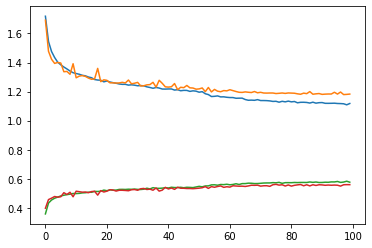

In [17]:
import pickle
pickle.dump(hist, open('./featureactv34_resnet50pretrained_hist2.hdf5', 'wb'))

plt.plot(hist), best_acc

In [20]:
# unfreeze to finetune

for param in model.conv1.parameters():
    param.requires_grad = True

for param in model.bn1.parameters():
    param.requires_grad = True

for param in model.layer1.parameters():
    param.requires_grad = True

for param in model.layer2.parameters():
    param.requires_grad = True

In [25]:
best_acc = 0.5617163555307885
hist = []

epochs=50
device = torch.device('cuda')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.00005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)

In [ ]:
model_path = './featureactv34_resnet50pretrained_finetune_model2.pt'

for epoch in range(50):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.1851825714111328 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [03:57<00:00,  1.06s/it]

- Avg.loss: 1.082 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145 | Avg. val_acc: 0.568
* Update optimal model
Epoch:  3


Loss=1.0372763872146606 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [03:57<00:00,  1.06s/it]

- Avg.loss: 1.070 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.582
* Update optimal model
Epoch:  4


Loss=1.2614834308624268 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [03:57<00:00,  1.06s/it]

- Avg.loss: 1.055 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.580
Epoch:  5


Loss=0.9369906783103943 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [03:57<00:00,  1.06s/it]

- Avg.loss: 1.047 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.585
* Update optimal model
Epoch:  6


Loss=0.9993138909339905 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [03:57<00:00,  1.06s/it]

- Avg.loss: 1.036 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.591
* Update optimal model
Epoch:  7


Loss=1.0874656438827515 Batch_id=74 Accuracy=0.609375:  33%|███▎      | 75/225 [01:20<02:37,  1.05s/it] 

([<matplotlib.lines.Line2D at 0x7f1ff635fa20>,
 0.6358317079966564)

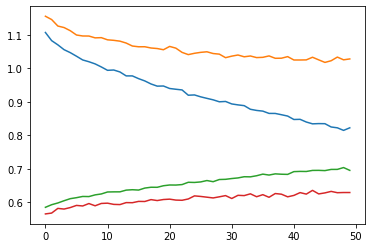

In [29]:
import pickle
pickle.dump(hist, open('featureactv34_resnet50pretrained_finetune_hist2.hdf5', 'wb'))

plt.plot(hist), best_acc

In [28]:
test_model = torch.load('featureactv34_resnet50pretrained_finetune_model2.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. val_loss: 1.004 | Avg. val_acc: 0.630
